# Importing tools

* Download datasets for this model here:

* https://drive.google.com/drive/folders/19TuTEOKfSOWr4IVf9PrTnN2TQiogoyYV?usp=sharing 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score


import warnings
warnings.filterwarnings("ignore")

# Importing and transforming data

 ### Here we deifne how to tansform the the data to fit our models
 
 * With the torchvision transformer function
 * We will randomly flip images horisontally for Data augmentaion with we hope to imporve our accuracy
 * We then transform the dataset into a Tensor.
 * Therafter normalize the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### We also have a transform function for our validation set

In [3]:
valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We define the training and test sets.

* Here we tell torchvision where the data is, then we load in the data with the DataLoader function
* we also split the data into a training set and a test set by using the train perameters, True or false

In [4]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Visualizing/analysing data

### Here we import the Pyplot to assess if the images are loaded correctly or not.

* Importing matplotlip and numpy.
* We define a function to show images from the train_loader dataset
* We create a grid with torchvision and imbed the images into the grid.

In [5]:
len(validation_set), len(test_set), len(train_set)

(10000, 10000, 50000)

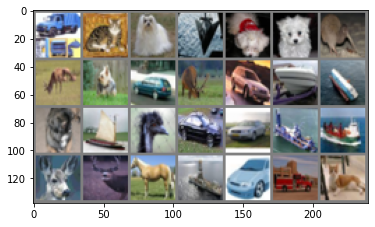

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

### Check how many images the training and testing datasets contain

In [7]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)


Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


### Get the classes of the entire dataset

In [8]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Get the Shapes of the images

In [9]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

### Print a sample image

Label (numeric): 6
Label (textual): frog


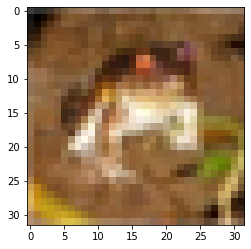

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Here we determine the number of images belonging to each class?

* We define the length of the dataset
* We then check hoe many classes there are
* We create a dictionary to store the values
* we then do 2 for loops, first to get the classes and the second to count the amount of images retaining to the classes 

In [11]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


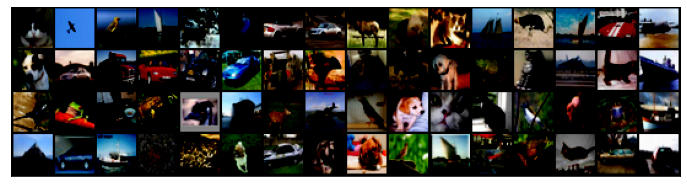

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

# Creating our CNN model

### Here we are creating the functionality for calculating the models accuracy

* Todo = Find out how this function works

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### ImageClassificationBase contains 4 functions
* One function is for training and validation sets, which implement the loss and accuracy.
* The validation_epoch_end combines the losses and accuracy for each epock 
* The epoch_end prints the val_lass and val_acc at the end of each epoch

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##### nn.Sequential chains the layres and activation functions into a single network architecture

In [15]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
print(Cifar10CnnModel)

<class '__main__.Cifar10CnnModel'>


### Here we move our model to GPU if it can run it

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("Model will run on, GPU")
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')


In [18]:
device = get_default_device()
device

Model will run on, GPU


device(type='cuda')

#### Here we load the data into the GPU device

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
ourmodel = Cifar10CnnModel()
ourmodel

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [22]:
ourmodel = to_device(ourmodel, device)

### The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(ourmodel, validation_loader)]
history

[{'val_acc': 0.10041799396276474, 'val_loss': 2.302720308303833}]

### Here we define the input and output size

In [25]:
input_size = 3*32*32
output_size = 10

### Number of epochs to cycle through and the learning rate is set here

In [26]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

# Training our model

In [27]:
history += fit(num_epochs, lr, ourmodel, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 1.6336, val_loss: 1.3639, val_acc: 0.5067
Epoch [1], train_loss: 1.1281, val_loss: 1.0423, val_acc: 0.6366
Epoch [2], train_loss: 0.8717, val_loss: 0.8979, val_acc: 0.6912
Epoch [3], train_loss: 0.7291, val_loss: 0.7592, val_acc: 0.7388
Epoch [4], train_loss: 0.6447, val_loss: 0.6778, val_acc: 0.7673
Epoch [5], train_loss: 0.5725, val_loss: 0.6703, val_acc: 0.7712
Epoch [6], train_loss: 0.5141, val_loss: 0.6361, val_acc: 0.7930
Epoch [7], train_loss: 0.4702, val_loss: 0.6242, val_acc: 0.7912
Epoch [8], train_loss: 0.4374, val_loss: 0.5987, val_acc: 0.8033
Epoch [9], train_loss: 0.4012, val_loss: 0.6231, val_acc: 0.8014


# Resnet, Importing and training

In [28]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
learning_rate = 0.001

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

resnet = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)


# Save the model checkpoint
torch.save(resnet.state_dict(), 'resnet.ckpt')

Epoch [1/10], Step [100/782] Loss: 1.5755
Epoch [1/10], Step [200/782] Loss: 1.3673
Epoch [1/10], Step [300/782] Loss: 1.1811
Epoch [1/10], Step [400/782] Loss: 1.2671
Epoch [1/10], Step [500/782] Loss: 1.3793
Epoch [1/10], Step [600/782] Loss: 1.0549
Epoch [1/10], Step [700/782] Loss: 1.2276
Epoch [2/10], Step [100/782] Loss: 0.8514
Epoch [2/10], Step [200/782] Loss: 1.0790
Epoch [2/10], Step [300/782] Loss: 0.7349
Epoch [2/10], Step [400/782] Loss: 0.8192
Epoch [2/10], Step [500/782] Loss: 0.8732
Epoch [2/10], Step [600/782] Loss: 0.7762
Epoch [2/10], Step [700/782] Loss: 0.7909
Epoch [3/10], Step [100/782] Loss: 0.9045
Epoch [3/10], Step [200/782] Loss: 0.9921
Epoch [3/10], Step [300/782] Loss: 0.6192
Epoch [3/10], Step [400/782] Loss: 0.8137
Epoch [3/10], Step [500/782] Loss: 0.7908
Epoch [3/10], Step [600/782] Loss: 0.6621
Epoch [3/10], Step [700/782] Loss: 0.7291
Epoch [4/10], Step [100/782] Loss: 0.7257
Epoch [4/10], Step [200/782] Loss: 0.7190
Epoch [4/10], Step [300/782] Loss:

# AlexNet

## Impoting the Model

In [29]:
from torchvision import models
alexnet = models.alexnet(pretrained=True)

### Evaluating the model layers

In [30]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Adjusting two of the model's layers to fit to CIFAR-10 dataset

In [31]:
import torch.nn as nn
# We need to change the classifiers to fit to the cifar 10 dataset
alexnet.classifier[4] = nn.Linear(4096,1024)
alexnet.classifier[6] = nn.Linear(1024,10)

#### Second evaluation after adjustments

In [32]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Reading the total parameters of the Alexnet

In [33]:
total_params = sum(p.numel() for p in alexnet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in alexnet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

44,428,106 total parameters.
44,428,106 training parameters.


#### Function for getting device, GPU or CPU

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        gpu_count = cuda.device_count()
        print(f'Model will run on GPU, {gpu_count} gpus detected.')
        if gpu_count > 1:
            multi_gpu = True
        else:
            multi_gpu = False
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')

#### Move AlexNet to GPU

In [35]:
# Move to gpu
alexnet = alexnet.to('cuda')

#### Adjust the Optimizer functions for AlexNet

In [36]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

### Create different transform functions for Alexnet

In [37]:
transfer_models_trandorm = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [38]:
transfer_valid_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We use a different format for Alexnet, since the model is optimized for 224px by 224px images

In [39]:
AlexNet_train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transfer_models_trandorm)
AlexNet_test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transfer_models_trandorm)

AlexNet_validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transfer_valid_transform)

AlexNet_train_loader = torch.utils.data.DataLoader(AlexNet_train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
AlexNet_test_loader = torch.utils.data.DataLoader(AlexNet_test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

AlexNet_validation_loader = torch.utils.data.DataLoader(AlexNet_validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Training Alexnet

In [40]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(AlexNet_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = alexnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training of AlexNet')

Finished Training of AlexNet


# Defining functions for Findings

In [41]:
def plot_matrix (confusion_matrix):
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
    plt.ylabel('Actual Category')
    plt.yticks(range(10), classes)
    plt.xlabel('Predicted Category')
    plt.xticks(range(10), classes)
    plt.show()

#### Defining the function that prints out the confusion matrix

In [42]:
def print_matrix (confusion_matrix):
    print('actual/pred'.ljust(16), end='')
    for i,c in enumerate(classes):
        print(c.ljust(10), end='')
    print()
    for i,r in enumerate(confusion_matrix):
        print(classes[i].ljust(16), end='')
        for idx, p in enumerate(r):
            print(str(p).ljust(10), end='')
        print()
        r = r/np.sum(r)
        print(''.ljust(16), end='')
        for idx, p in enumerate(r):
            print(str(p).ljust(10), end='')
        print()

In [43]:
def prf1(confusion_matrix):
    TP = 0
    FP = 0
    FN = 0

    for i,r in enumerate(confusion_matrix):
        total = 0
        thisTP = 0
        thisFN = 0
        thisFP = 0 
        for i3 in range (0,10):
            if (i != i3):
                thisFP += confusion_matrix[i3][i]
        for i2,r2 in enumerate(r):
            total += r2
            if (i == i2):
                thisTP += r2
            else:
                thisFN += r2

        print(classes[i])
        print('True positives %d' % (thisTP))
        print('False positives %d' % (thisFP))
        print('False negatives %d' % (thisFN))
        precision = thisTP / (thisTP + thisFP)
        recall = thisTP / (thisTP + thisFN)
        print('Precicion {}'.format(precision))
        print('Recall {}'.format(recall))
        f1 = (2 * (precision*recall)) / (precision + recall)
        print('F1 {}'.format(f1))

In [44]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs'); 

In [45]:
def plot_losses_epochs(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    

# Function for testing each model with test_set and Dataset-b

In [46]:
def test_model(model, data_to_test):    
    # prepare to count predictions for each class
    # correct_pred = {classname: 0 for classname in classes}
    # total_pred = {classname: 0 for classname in classes}
    correct_pred = list(0. for i in range(10))
    total_pred = list(0. for i in range(10))
    y_actual = []
    y_pred = []
    confusion_matrix = np.zeros([10,10], int)

    # again no gradients needed
    with torch.no_grad():
        for data in data_to_test:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                correct_pred[label] += c[i].item()
                total_pred[label] += 1
            for i, l in enumerate(labels):
                y_actual.append(l.item())
                y_pred.append(predicted[i].item())
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    return correct_pred, total_pred, y_actual, y_pred, confusion_matrix

# Our model findings

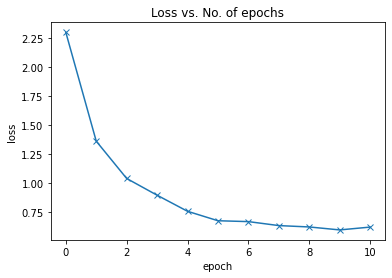

In [47]:
plot_losses(history)

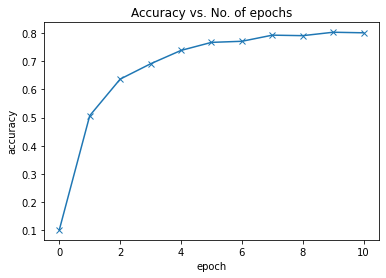

In [48]:
plot_accuracies(history)

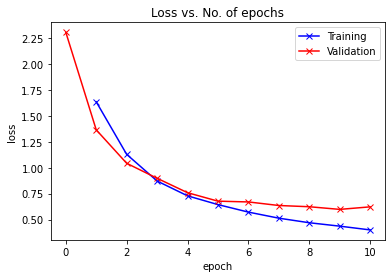

In [49]:
plot_losses_epochs(history);

In [50]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(ourmodel, test_loader)

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * correct_pred[i] / total_pred[i]))

Accuracy of airplane : 83 %
Accuracy of automobile : 94 %
Accuracy of  bird : 63 %
Accuracy of   cat : 53 %
Accuracy of  deer : 78 %
Accuracy of   dog : 79 %
Accuracy of  frog : 83 %
Accuracy of horse : 93 %
Accuracy of  ship : 86 %
Accuracy of truck : 92 %


In [51]:
avg = 0
for i in range(10):
  temp = (100 * correct_pred[i] / total_pred[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  80.8680363622283


In [52]:
matthews_corrcoef(y_actual, y_pred)

0.7798349371830812

In [53]:
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.90      0.92      0.91      1000
        bird       0.80      0.67      0.73      1000
         cat       0.70      0.58      0.63      1000
        deer       0.77      0.76      0.76      1000
         dog       0.74      0.75      0.74      1000
        frog       0.85      0.82      0.84      1000
       horse       0.74      0.90      0.81      1000
        ship       0.89      0.87      0.88      1000
       truck       0.82      0.92      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [54]:
cohen_kappa_score(y_actual, y_pred)

0.7793333333333333

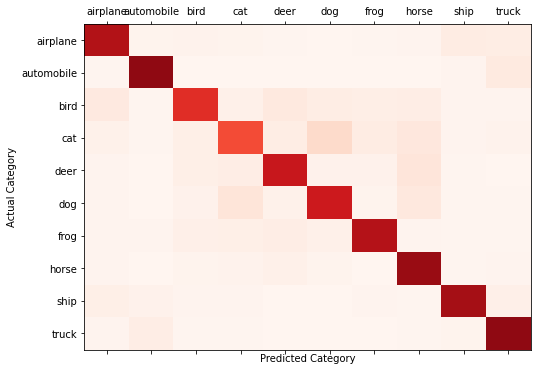

In [55]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

# AlexNet Findings


In [56]:
correct = 0
total = 0
with torch.no_grad():
    for data in AlexNet_test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 89 %


In [57]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(alexnet, AlexNet_test_loader)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

Accuracy of airplane : 96 %
Accuracy of automobile : 92 %
Accuracy of  bird : 84 %
Accuracy of   cat : 80 %
Accuracy of  deer : 90 %
Accuracy of   dog : 84 %
Accuracy of  frog : 92 %
Accuracy of horse : 95 %
Accuracy of  ship : 96 %
Accuracy of truck : 97 %


In [58]:
avg = 0
for i in range(10):
  temp = (100 * correct_pred[i] / total_pred[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  91.18727338709957


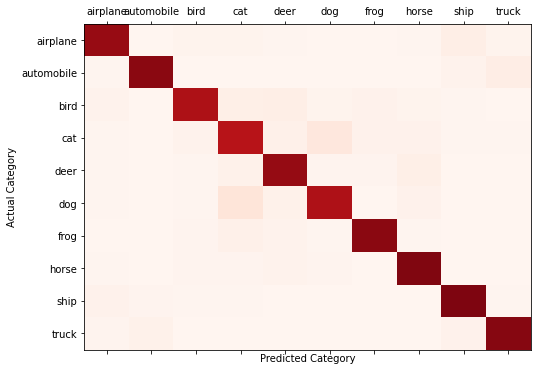

In [59]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [60]:
matthews_corrcoef(y_actual, y_pred)

0.8888737516951075

In [61]:
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.92      0.90      0.91      1000
  automobile       0.96      0.93      0.94      1000
        bird       0.92      0.85      0.88      1000
         cat       0.79      0.82      0.80      1000
        deer       0.87      0.91      0.89      1000
         dog       0.88      0.84      0.86      1000
        frog       0.94      0.93      0.93      1000
       horse       0.89      0.95      0.92      1000
        ship       0.91      0.95      0.93      1000
       truck       0.92      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [62]:
cohen_kappa_score(y_actual, y_pred)

0.8887777777777778

# Resnet Findings


In [63]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(resnet.state_dict(), 'resnet.ckpt')

Accuracy of the model on the test images: 82.5 %


In [64]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(resnet, test_loader)


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

Accuracy of airplane : 89 %
Accuracy of automobile : 92 %
Accuracy of  bird : 83 %
Accuracy of   cat : 68 %
Accuracy of  deer : 80 %
Accuracy of   dog : 72 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 91 %
Accuracy of truck : 91 %


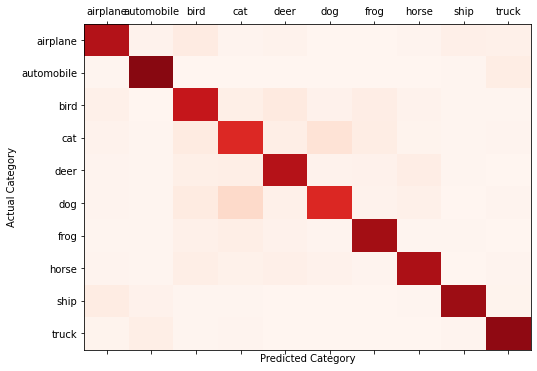

In [65]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [66]:
avg = 0
for i in range(10):
  temp = (100 * correct_pred[i] / total_pred[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  84.71809046422146


In [67]:
matthews_corrcoef(y_actual, y_pred)

0.8066764674935745

In [68]:
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.84      0.82      0.83      1000
  automobile       0.90      0.93      0.91      1000
        bird       0.72      0.77      0.74      1000
         cat       0.69      0.69      0.69      1000
        deer       0.79      0.82      0.81      1000
         dog       0.79      0.69      0.74      1000
        frog       0.86      0.88      0.87      1000
       horse       0.87      0.85      0.86      1000
        ship       0.92      0.89      0.91      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [69]:
cohen_kappa_score(y_actual, y_pred)

0.8065555555555556

# Import Dataset-b

* At first we had to import our data and transform them into png's. After which we exported them to seporate folders by their classes.
* Each folder name being the name of the class
* We can then import them with the Torchvision.dataset api, using ImageFolder, so we have the same structure as the CIFAR-10 dataset

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
unseen_set = torchvision.datasets.ImageFolder('/content/drive/MyDrive/AAI_Exam/datasets/NEW_PNGS/', transform=valid_transform)

Alex_unseen_set = torchvision.datasets.ImageFolder('/content/drive/MyDrive/AAI_Exam/datasets/NEW_PNGS/', transform=transfer_valid_transform)

unseen_loader = torch.utils.data.DataLoader(unseen_set, batch_size=64,
                                          shuffle=False, num_workers=4)

Alex_unseen_loader = torch.utils.data.DataLoader(Alex_unseen_set, batch_size=64,
                                          shuffle=False, num_workers=4)

batch_size=128

# Testing on AlexNet Dataset-b images 

In [72]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(alexnet, Alex_unseen_loader)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

Accuracy of airplane : 62 %
Accuracy of automobile : 75 %
Accuracy of  bird : 83 %
Accuracy of   cat : 78 %
Accuracy of  deer : 92 %
Accuracy of   dog : 75 %
Accuracy of  frog : 91 %
Accuracy of horse : 83 %
Accuracy of  ship : 100 %
Accuracy of truck : 83 %


In [73]:
avg = 0
for i in range(10):
  temp = (100 * correct_pred[i] / total_pred[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  82.55952380952381


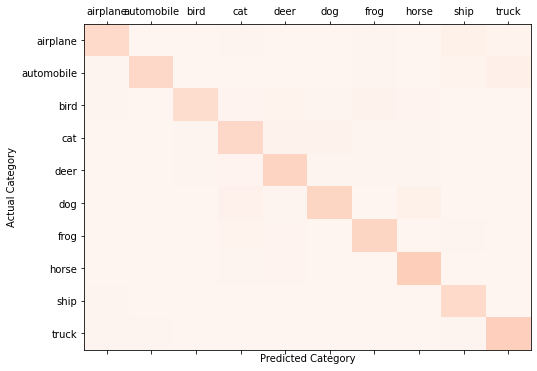

In [74]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [75]:
matthews_corrcoef(y_actual, y_pred)

0.7608609847666928

In [76]:
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.84      0.71      0.77       208
  automobile       0.92      0.71      0.80       212
        bird       0.86      0.67      0.76       202
         cat       0.67      0.72      0.70       212
        deer       0.74      0.81      0.78       204
         dog       0.83      0.74      0.78       218
        frog       0.80      0.84      0.82       192
       horse       0.77      0.88      0.82       210
        ship       0.70      0.90      0.79       161
       truck       0.77      0.89      0.83       202

    accuracy                           0.78      2021
   macro avg       0.79      0.79      0.78      2021
weighted avg       0.79      0.78      0.78      2021



In [77]:
cohen_kappa_score(y_actual, y_pred)

0.7597636635254512

# Testing on ResNet Dataset-b data

In [78]:
type(unseen_loader)

torch.utils.data.dataloader.DataLoader

In [79]:
batch_size=64
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(resnet, unseen_loader)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

Accuracy of airplane : 12 %
Accuracy of automobile : 33 %
Accuracy of  bird : 25 %
Accuracy of   cat :  7 %
Accuracy of  deer : 21 %
Accuracy of   dog : 33 %
Accuracy of  frog :  8 %
Accuracy of horse :  8 %
Accuracy of  ship : 33 %
Accuracy of truck : 16 %


In [80]:
avg = 0
for i in range(10):
  temp = (100 * correct_pred[i] / total_pred[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  19.940476190476193


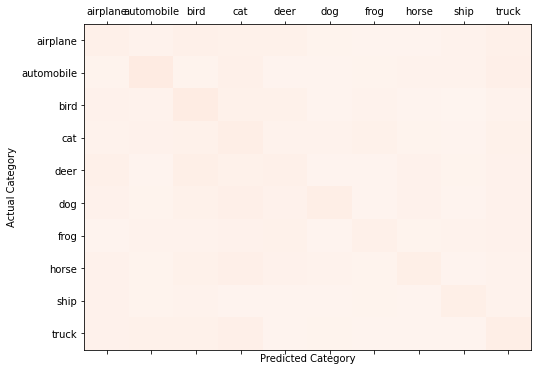

In [81]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [82]:
matthews_corrcoef(y_actual, y_pred)

0.10516198922070887

In [83]:
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.14      0.15      0.15       208
  automobile       0.27      0.27      0.27       212
        bird       0.19      0.25      0.22       202
         cat       0.14      0.19      0.16       212
        deer       0.15      0.15      0.15       204
         dog       0.27      0.19      0.22       218
        frog       0.20      0.16      0.18       192
       horse       0.23      0.18      0.20       210
        ship       0.24      0.22      0.23       161
       truck       0.17      0.20      0.18       202

    accuracy                           0.19      2021
   macro avg       0.20      0.20      0.20      2021
weighted avg       0.20      0.19      0.20      2021



In [84]:
cohen_kappa_score(y_actual, y_pred)



0.10488558470760523

# Testing on our model

In [85]:
correct_pred, total_pred, y_actual, y_pred, confusion_matrix = test_model(ourmodel, unseen_loader)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct_pred[i] / total_pred[i]))

Accuracy of airplane : 43 %
Accuracy of automobile : 50 %
Accuracy of  bird : 41 %
Accuracy of   cat : 57 %
Accuracy of  deer : 78 %
Accuracy of   dog : 75 %
Accuracy of  frog : 66 %
Accuracy of horse : 66 %
Accuracy of  ship : 75 %
Accuracy of truck : 66 %


In [86]:
avg = 0
for i in range(10):
  temp = (100 * correct_pred[i] / total_pred[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  62.11309523809524


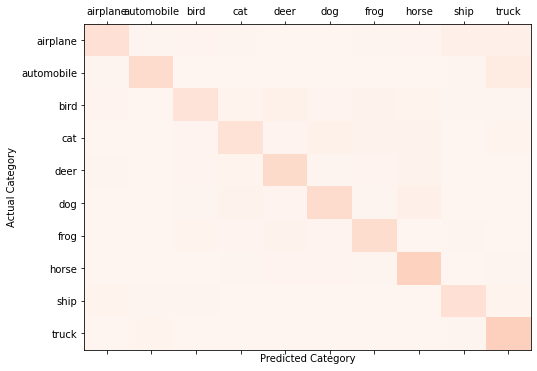

In [87]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Reds'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [88]:
matthews_corrcoef(y_actual, y_pred)

0.6260589365656097

In [89]:
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.74      0.55      0.63       208
  automobile       0.80      0.66      0.72       212
        bird       0.66      0.50      0.57       202
         cat       0.60      0.53      0.56       212
        deer       0.65      0.69      0.67       204
         dog       0.69      0.63      0.66       218
        frog       0.68      0.69      0.68       192
       horse       0.62      0.80      0.70       210
        ship       0.66      0.71      0.68       161
       truck       0.60      0.87      0.71       202

    accuracy                           0.66      2021
   macro avg       0.67      0.66      0.66      2021
weighted avg       0.67      0.66      0.66      2021



In [90]:
cohen_kappa_score(y_actual, y_pred)

0.6243840953674937